In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [2]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
def preprocess(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255
    return np.where(images>0.5, 1.0, 0.0).astype("float32")
train_images = preprocess(train_images)
test_images = preprocess(test_images)

In [4]:
batch_size = 32
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_images.shape[0]).batch(batch_size))

In [5]:
class CVAE(keras.Model):
    def __init__(self, n_z):
        super(CVAE, self).__init__()
        self.n_z = n_z
        self.encoder = keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=(28,28,1)),
            keras.layers.Conv2D(filters=32,
                               kernel_size=3,
                               strides=(2,2),
                               activation="relu"),
            keras.layers.Conv2D(filters=64,
                               kernel_size=3,
                               strides=(2,2),
                               activation='relu'),
            keras.layers.Flatten(),
            keras.layers.Dense(n_z + n_z)
        ])
        self.decoder = keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=(n_z,)),
            keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            keras.layers.Reshape(target_shape=(7,7,32)),
            keras.layers.Conv2DTranspose(filters=64,
                                        kernel_size=3,
                                        strides=2,
                                        padding='same',
                                        activation='relu'),
            keras.layers.Conv2DTranspose(filters=32,
                                        kernel_size=3,
                                        strides=2,
                                        padding='same',
                                        activation='relu'),
            keras.layers.Conv2DTranspose(filters=1,
                                        kernel_size=3,
                                        strides=1,
                                        padding='same')
        ])
        
    def encode(self, x):
        encoder_out = self.encoder(x)
        mean, logvar = tf.split(encoder_out, num_or_size_splits=2, axis=1)
        return mean, logvar

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(logits) #probs
        return logits

#    @tf.function
    def decode_with_sigmoid(self, z):
        return self.decode(z, apply_sigmoid=True)
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

In [6]:
def log_normal_pdf(a, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(-0.5 * ((a-mean)**2.0 * tf.exp(-logvar) + logvar + log2pi),
                        axis=raxis)

In [7]:
def compute_loss(model, x):
    #propogate
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit,
                                                       labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.) #prior
    logqz_x = log_normal_pdf(z, mean, logvar) #posterior
    
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [8]:
optimizer = keras.optimizers.Adam(1e-4)

In [9]:
@tf.function
def train_step(model, x, optimizer):
    #Compute loss
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    #Update params using gradient
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [10]:
def image_comparison(model, epoch, x_test):
    mean, logvar = model.encode(x_test)
    z = model.reparameterize(mean, logvar)
    #print(z)
    x_pred = model.decode_with_sigmoid(z)
    #print(x_pred)
    fig = plt.figure(figsize=(5,2))
    for i in range(x_test.shape[0]):
        plt.subplot(5,2, i*2+1)
        plt.imshow(x_test[i,:,:,0], cmap='gray')
        plt.axis("off")
        plt.subplot(5,2, i*2+2)
        plt.imshow(x_pred[i,:,:,0], cmap='gray')
        plt.axis("off")
    plt.savefig(f'image_at_epoch{epoch}.png')
    plt.show()

In [11]:
epochs = 3
n_z = 2

In [13]:
for test_batch in test_dataset.take(1):
    x_test = test_batch[0:5,:,:,:]

In [15]:
model = CVAE(n_z)

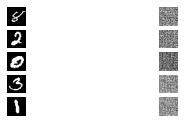

In [16]:
image_comparison(model, 0, x_test)

100%|██████████| 313/313 [00:09<00:00, 33.46it/s]


Epoch:1, test ELBO:-177.13388061523438, time 81.08989214897156


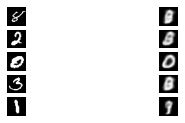

100%|██████████| 313/313 [00:09<00:00, 33.00it/s]


Epoch:2, test ELBO:-170.7563934326172, time 73.44528269767761


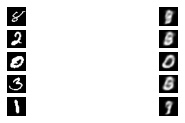

100%|██████████| 313/313 [00:09<00:00, 33.25it/s]


Epoch:3, test ELBO:-166.65310668945312, time 77.95068597793579


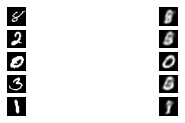

In [17]:
for epoch in range(1, epochs+1):
    start_time = time.time()
    for train_x in tqdm(train_dataset):
        train_step(model, train_x, optimizer)
    end_time = time.time()
    loss = keras.metrics.Mean()
    for test_x in tqdm(test_dataset):
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    print(f"Epoch:{epoch}, test ELBO:{elbo}, time {end_time-start_time}")
    image_comparison(model, epoch, x_test)

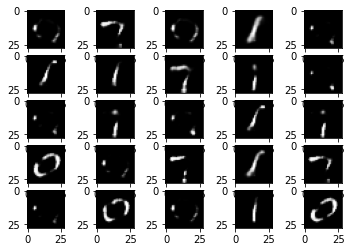

In [20]:
z_test = tf.random.uniform(shape=[25, n_z], minval=-10, maxval=10)
z_pred = model.decode_with_sigmoid(z_test)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(z_pred[i,:,:,0], cmap='gray')